# Wells Fargo Pricing Data

## Description of data

The attached data file (skills_test.csv) contains text data pertaining to Wells Fargo, a US bank. This data includes documents sourced from a variety of 
platforms including Twitter, Facebook, blogs and forums.

There are two columns in the data file. `Text` contains the main data. `label` contains a binary label indicating whether the document is about `pricing` (1)
or not (0).

## Description of tasks

You have two tasks:
1. classify documents based on whether or not they discuss pricing
2. summarise the dataset

These tasks give us insight into your technical and methodological knowledge as well as your curiosity, creativity and ability to pick up new methods quickly. Good luck!

- [Task 1: classification](#task1)
  - [Exploration and preprocessing](#exploration-preprocessing)
  - [Models](#models)
    - [tf–idf + LogisticRegression](#tf-idf)
    - [Average of word embeddings](#average-embeddings)
    - [sentence-transformers](#sentence-transformers)
    - [Fine tuning BERT ](#fine-tune)
  - [Results](#results)
- [Task 2: describe & summarise](#task2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score

import re
import string

import nltk
import spacy

import torch
from torchinfo import summary
from torchtext.legacy.data import Field
from torchtext.vocab import GloVe, Vectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from datasets import Dataset, load_metric

from tqdm import tqdm, trange
import os
from wordcloud import WordCloud, STOPWORDS

from utils import preprocessing

nlp = spacy.load('en_core_web_md')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# Reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

<a name = "task1"></a>
## Task 1: classification

Your task is to correctly classify the documents into classes 0 and 1 (i.e. about 'pricing' or not).

You will get extra "points" for trying a variety of NLP relevant classification approaches. What is the state of the art? What is the most achievable in the timeframe? 

We want to see a notebook or script summarising the techniques you tried and the results you received. We're interested in how you quantify the  results of the various techniques that you try too please so don't forget to report that. The F1 score (harmonic mean) is a good option here.

<a name = "exploration-preprocessing"></a>
### Exploration and preprocessing

It appears that the texts come from different sources, like Twitter, Reddit, reviews, etc.

In [31]:
data = pd.read_csv('data/skills_test.csv')
data.head()

,Text,label
0,I bought a car through a dealership and had so...,1
1,"April 7, 2006 Wells Fargo Bank announced they ...",1
2,Securities watchdog investigates Wells Fargo o...,1
3,I had a problem where for months my student lo...,1
4,If someone opens a bank account without your k...,1


The classes are actually perfectly balanced, so a metric like accuracy works perfectly fine.

In [32]:
data['label'].value_counts()

1    1914
0    1914
Name: label, dtype: int64

On average, each text has 65 words. We could use create some features, like length of the text, to make the classification, but that will take time so I prefer to use only the contents of the texts 

In [33]:
data['Text'].apply(lambda text: len(text.split())).mean()

64.94148380355277

I applied the following preprocessing:

- Convert to lowercase
- Remove urls
- Remove whitespaces like `\n` and `\t`
- Simplify repeated punctuation symbols that appear more than 2 times, for example, "whats up??!!!!!" -> "whats up?!"

I didn't remove stop words and I didn't lemmatize because I prefer to keep the text as *'natural'* as possible for the more complex models.

In [34]:
data['Text'] = data['Text'].apply(lambda text: preprocessing.preprocess_text(text))

There are only 3,828 examples, which is not too much, so I will use 80\% for train and 20\% for test.

In [35]:
train, test = train_test_split(data, train_size=0.8, shuffle=True, random_state=42)

<a name = "models"></a>
### Models

<a name = "tf-idf"></a>
#### tf–idf + LogisticRegression

For a baseline model I will use a tf–idf matrix as the features and a logistic regression for the classifier. 

In [8]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words=None, lowercase=True, ngram_range=(1,1))
vectorizer.fit(train['Text'])

X_train = vectorizer.transform(train['Text'])
X_test = vectorizer.transform(test['Text'])

In [9]:
clf = LogisticRegression(max_iter=1000, penalty='l2')
clf.fit(X_train, train['label'])

y_pred = clf.predict(X_test)
print(f'F1: {f1_score(test["label"], y_pred):.4f}')
print(f'Confusion matrix: \n{confusion_matrix(test["label"], y_pred)}')

F1: 0.8963
Confusion matrix: 
[[335  34]
 [ 47 350]]


<a name = "average-embeddings"></a>

#### Average of word embeddings

To extract the features of each sentence we can use word embeddings and get the average vector of each sentence by adding up the embedding of each token. To do this we can use pretrained embeddings, like the ones from [GloVe](https://nlp.stanford.edu/projects/glove/). 

As I mentioned before the data seems to come from Twitter, Reddit, reviews and possibly others social networks, for this reason I will use the embeddings `glove.twitter.27B.200d`, which were trained in a Twitter corpus, which is similar to the data we have. This is a really simple approach to get embeddings of sentences and/or paragraphs.

In [10]:
def mean_vector(text, text_field):
    """
    Get the mean vector/embedding of a text by adding up the 
    embedding of each token.
    
    Parameters
    ----------
    text: str.
        Text that will be processed.
                
    text_field: torchtext.legacy.data.field.Field.
        Instance of Field that will be used to process the text.
    """
    tokens = np.array([text_field.vocab[token] for token in text_field.preprocess(text)])
    vectors = np.array([text_field.vocab.vectors[token].numpy() for token in tokens])
    
    return np.mean(vectors, axis=0)

In [11]:
# Define how the text will be preprocessed
text_field = Field(lower=True, tokenize='spacy', tokenizer_language='en_core_web_md')

# This may take a while because it downloads the embeddings
text_field.build_vocab(train['Text'].apply(lambda text: text_field.preprocess(text)), 
                       vectors='glove.twitter.27B.200d', 
                       vectors_cache='.vector_cache')

In [12]:
# Get the embedding of each sentence
X_train = np.array([mean_vector(text, text_field) for text in train['Text']])
X_test = np.array([mean_vector(text, text_field) for text in test['Text']])

In [13]:
clf = LogisticRegression(max_iter=1000, penalty='l2')
clf.fit(X_train, train['label'])

y_pred = clf.predict(X_test)
print(f'F1: {f1_score(test["label"], y_pred):.4f}')
print(f'Confusion matrix: \n{confusion_matrix(test["label"], y_pred)}')

F1: 0.8134
Confusion matrix: 
[[305  64]
 [ 81 316]]


<a name = "sentence-transformers"></a>
#### sentence-transformers

There are better ways to create embeddings for sentences and/or paragraphs, for instance, we can use [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html), that allows us to learn paragraph and document embeddings, however, there are no pretrained models for this library as far as I know and it gives rather poor results if I train it from scratch.

Another way is with [sentence-transformers](https://github.com/UKPLab/sentence-transformers), which provides an easy method to compute dense vector representations for sentences, paragraphs, and images. They have multiple [pretrained-models](https://www.sbert.net/docs/pretrained_models.html), I will use `all-mpnet-base-v2` which is an all-round model tuned for many use-cases and has the best performance.

In [14]:
# The model can use the GPU, but I will need the memory of the GPU later to fine-tune
sentence_bert = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')

In [15]:
summary(sentence_bert)

Layer (type:depth-idx)                                       Param #
SentenceTransformer                                          --
├─Transformer: 1-1                                           --
│    └─BertModel: 2-1                                        --
│    │    └─BertEmbeddings: 3-1                              11,918,592
│    │    └─BertEncoder: 3-2                                 10,646,784
│    │    └─BertPooler: 3-3                                  147,840
├─Pooling: 1-2                                               --
├─Normalize: 1-3                                             --
Total params: 22,713,216
Trainable params: 22,713,216
Non-trainable params: 0

In [16]:
# X_train = sentence_bert.encode(train['Text'].tolist(), device='cpu')
# X_test = sentence_bert.encode(test['Text'].tolist(), device='cpu')

In [17]:
clf = LogisticRegression(max_iter=1000, penalty='l2')
clf.fit(X_train, train['label'])

y_pred = clf.predict(X_test)
print(f'F1: {f1_score(test["label"], y_pred):.4f}')
print(f'Confusion matrix: \n{confusion_matrix(test["label"], y_pred)}')

F1: 0.8134
Confusion matrix: 
[[305  64]
 [ 81 316]]


<a name = "fine-tune"></a>
#### Fine tuning BERT  

So far I have been using a simple LogisticRegression for the classification, now I will fine-tune [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english), which is one of the models HuggingFace recommends for text classification. I will use the hyperparameters recommended for fine-tuning they put on the model card.

In [18]:
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'

tokenizer = AutoTokenizer.from_pretrained(model_name, return_tensors='pt')
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

We can further change the `classifier` layers, but this will do for the moment.

In [19]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           1,538
├─Dropout: 1-4                                          --
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0

First we have to create de datasets.

In [20]:
def tokenize_function(examples):
    return tokenizer(examples['Text'], max_length=128, padding='max_length', truncation=True)

train_dataset = Dataset.from_pandas(train).map(tokenize_function, batched=True)
eval_dataset = Dataset.from_pandas(test).map(tokenize_function, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

For the metric I will use the F1.

In [21]:
metric = load_metric('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

I will use the hyperparameters recommended in [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english), but I have to reduce `batch_size` because my GPU runs out of memory.

In [22]:
# They recommend batch_size=32, but my GPU runs out of memory, so I will use 8 instead
training_args = TrainingArguments(
    output_dir='training', 
    learning_rate=1e-5, 
    per_device_train_batch_size=8,
    warmup_steps=600, 
    num_train_epochs=3,
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset, 
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

In [23]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Text, __index_level_0__.
***** Running training *****
  Num examples = 3062
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1149


Epoch,Training Loss,Validation Loss,F1
1,No log,0.531496,0.758123
2,1.131100,0.271255,0.881806
3,0.256100,0.297548,0.906290


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 766
  Batch size = 8
Saving model checkpoint to training/checkpoint-500
Configuration saved in training/checkpoint-500/config.json
Model weights saved in training/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 766
  Batch size = 8
Saving model checkpoint to training/checkpoint-1000
Configuration saved in training/checkpoint-1000/config.json
Model weights saved in training/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: 

TrainOutput(global_step=1149, training_loss=0.628140749155282, metrics={'train_runtime': 92.2262, 'train_samples_per_second': 99.603, 'train_steps_per_second': 12.458, 'total_flos': 304211381013504.0, 'train_loss': 0.628140749155282, 'epoch': 3.0})

In [24]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 766
  Batch size = 8


{'eval_loss': 0.2975483536720276,
 'eval_f1': 0.9062901155327343,
 'eval_runtime': 1.7749,
 'eval_samples_per_second': 431.576,
 'eval_steps_per_second': 54.088,
 'epoch': 3.0}

Now let's see some examples.

In [25]:
if torch.cuda.is_available():
    model_pipeline = pipeline(task='text-classification', model=model, tokenizer=tokenizer, device=0)

    examples = [
        'April 7, 2006 Wells Fargo Bank announced they finally invested $5 million of the $1 billion intended for renewable energy.', # POSIIVE (1)
        'I am quite hungry'                                                                                                           # NEGATIVE (0)
    ]
    
    print(model_pipeline(examples))

Disabling tokenizer parallelism, we're using DataLoader multithreading already


[{'label': 'POSITIVE', 'score': 0.7423076033592224}, {'label': 'NEGATIVE', 'score': 0.9992892742156982}]


### Results

For the first three models I focused more in the features and I used the same classifier. To be relatively simple the tf-idf feautures do a rather good job, moreover, it is fast to train and to make predictions.

For the fourth model we combine complex features from DistilBERT and a more complex classifier which is composed of the last layers of the network, the F1 score improves but not too much, moreover, this model is really computationally expensive (both for training and to make predictions). There are others pretrained models that could be better for the data we have, like [ProsusAI/finbert](https://huggingface.co/ProsusAI/finbert) or [iyanghkust/finbert-tone](https://huggingface.co/yiyanghkust/finbert-tone), which were trained with financial data (similar to the data we have), but I have to be more careful with the classifier layer and do it in native PyTorch, which takes a little more time.

So, which model should we choose? If you have a lot of computational resources go for the fine-tuned BERT model, but if you don't have too much computational resources or speed is really important then go for the tf-idf model.

|                    **Model**                    | **F1-score** |
|:-----------------------------------------------:|:------------:|
|           tf-idf + LogisticRegression           |     89.63    |
| Average of word embeddings + LogisticRegression |     81.34    |
|   sentence-transformers  +  LogisticRegression  |     82.13    |
|                 Fine tuning BERT                |     90.62    |

<a name = "task2"></a>
## Task 2: describe & summarise

We are also interested in your ability to make sense of the data. Please tell us what's in this dataset? Here are some areas that you might consider 
looking into to help tell your story: frequent terms, topic modelling (LDA, word2vec, etc.), influential users, sentiment, emotion, network diagrams, etc. 

### Word cloud

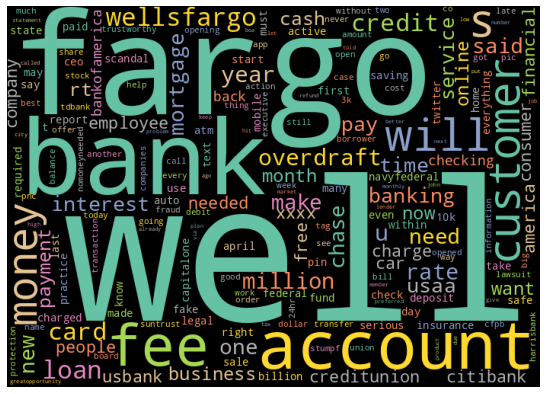

In [96]:
text = data['Text'].apply(lambda text: text + ' ').sum()

# Create and generate a word cloud image:
wordcloud = WordCloud(width=700, height=500, stopwords=STOPWORDS, 
                      colormap='Set2', random_state=42, collocations=False)
wordcloud = wordcloud.generate(text)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## What we need from you at the end

Please provide us with the script(s) (preferably in a notebook format) you 
used to create your outputs as well as a write-up of your findings (you 
could integrate this into your notebook, or a separate document). Please also 
include any supporting visuals (these could be embedded in your notebook, 
a Word file, PowerPoint, etc.). Story-telling and clarity is important here!

Also note this isnt a test in the form of right and wrong answers, we want to do a mini-emulation of how you would approach this kind of R&D task at Kantar. Also we will discuss with you your work here in the 2nd stage interviews so please be prepared to say why you made the decisions you made and understand what approaches you have implemented. 

Be creative and clear, and have fun!

Live long and prosper 🖖